In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import PIL
import os
from sys import platform
from importlib import reload

# Local imports
import sys
sys.path.append('../')
import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import fourierstuff as fs

In [2]:
%matplotlib notebook

In [3]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [4]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [5]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd(); startpos = len(pwd)-pwd[::-1].find(slash)
case = pwd[startpos:]; print(case)
Segmentroot='Segments2'; print(Segmentroot)

Case2.1
Segments2


In [6]:
# Derivative names
Compressedfilename = Segmentroot+'retrieved.npz'; print (Compressedfilename)
Originalfilename = Segmentroot+'_compr.npz'; print(Originalfilename)
Flattenedfilename = Segmentroot+'_compr_flat.npz'; print(Flattenedfilename)
Filteredfilename = Segmentroot+'_compr_flat_filt.npz'; print(Filteredfilename)

Segments2retrieved.npz
Segments2_compr.npz
Segments2_compr_flat.npz
Segments2_compr_flat_filt.npz


In [7]:
# Get the retrieved surface
npzfile = np.load(Compressedfilename)
imageroot = np.array_str(npzfile['imageroot'])
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("dx and dy", dx, dy)

dx and dy 0.5669643 0.5669643


In [8]:
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
solution = npzfile['solution']
nsegments = len(nx1list)

<IPython.core.display.Javascript object>


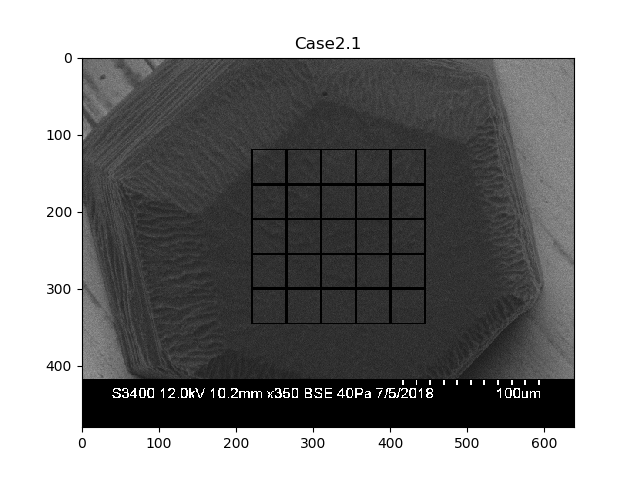

Text(0.5,1,'Case2.1')

In [9]:
# Graph the segments
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)
plt.imshow(np.asarray(im),cmap = 'Greys_r', vmin = 0,vmax = 255)
plt.title(case)

In [10]:
# Flatten them
xseggrid, yseggrid, zseggrid, surf_xseggrid, surf_yseggrid, surf_zseggrid = ims.extractflat(npzfile,dx,dy)

In [11]:
# Report
print(np.shape(zseggrid[0]), \
      xseggrid[0][0,1]-xseggrid[0][0,0],yseggrid[0][1,0]-yseggrid[0][0,0])
print(np.shape(surf_zseggrid[0]), \
      surf_xseggrid[0][0,1]-surf_xseggrid[0][0,0],surf_yseggrid[0][1,0]-surf_yseggrid[0][0,0])

(42, 42) 0.5669643 0.5669643
(46, 46) 0.5669643 0.5669643


<IPython.core.display.Javascript object>


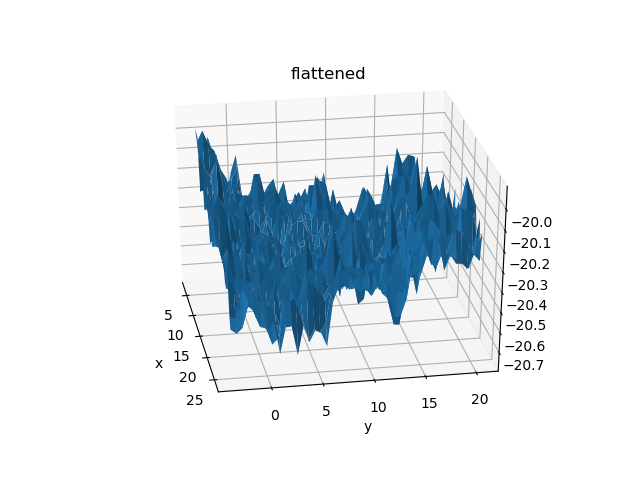

Segments2_compr_flat_14.stl
Creating top mesh...


<IPython.core.display.Javascript object>


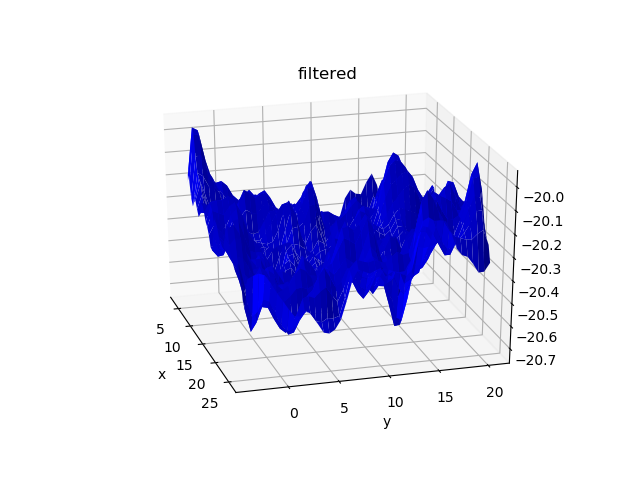

Segments2_compr_flat_filt_14.stl
Creating top mesh...
std dev of height =  0.1170571498782877


<IPython.core.display.Javascript object>


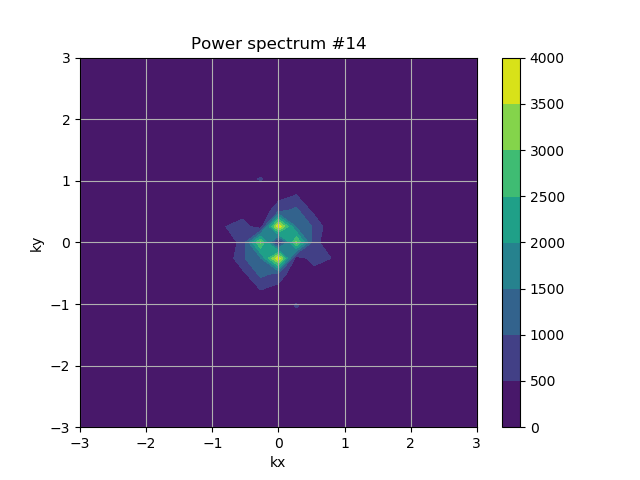

In [14]:
# Fourier transform, filter, and save them
plotthisone = [14]
vscale = 5
kmax = 3.0
xseggrid_filtered = []
yseggrid_filtered = []
zseggrid_filtered = []

for i in range(nsegments):
    
    # Get the next flattened surface
    xgrid = xseggrid[i]
    ygrid = yseggrid[i]
    sollast = zseggrid[i]
    x = xgrid[0,:]; dx = x[1]-x[0]
    y = ygrid[:,0]
    Ny, Nx = np.shape(sollast)

    # Fourier transform it
    sollast_offset = np.mean(sollast)
    sollast_atzero = sollast-sollast_offset
    sollast_FTshift,kxshift,kyshift = fs.FT(sollast_atzero,x,y)

    # This makes gridded versions of the k-arrays
    kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift);

    # Find the absolute square
    sollast_FTshift_square = np.real(sollast_FTshift)**2 +  np.imag(sollast_FTshift)**2 

    # Make a copy of the Fourier representation
    sollast_FTshift_filtered = sollast_FTshift*1

    # Apply a mask
    for ix in range(Nx):
        for iy in range(Ny):
            ktest = np.sqrt(kxshiftgrid[iy,ix]**2+kyshiftgrid[iy,ix]**2)
            if(ktest>kmax):
                sollast_FTshift_filtered[iy,ix]=0

    # Inverse FT
    sollast_FT_filtered_IFT = fs.IFT(sollast_FTshift_filtered)+sollast_offset
    sollast_FT_filtered_IFT_real = np.real(sollast_FT_filtered_IFT)
    
    # Plot one of them
    if i in plotthisone:
        
        # Graphing the flattened surface as a mesh
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xseggrid[i], yseggrid[i], zseggrid[i])
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('flattened')
        ax.view_init(30, -10)
                
        # Save an stl file
        stlfilename = Segmentroot+'_compr_flat'+'_'+str(i)+'.stl'; print(stlfilename)
        sls.numpy2stl(np.fliplr(zseggrid[i]), stlfilename, scale=dx*vscale, solid=False)

        # Graphing the filtered flattened surface as a mesh
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(xseggrid[i], yseggrid[i], sollast_FT_filtered_IFT_real,color='blue')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('filtered')
        ax.view_init(30, -10)
        
        # Save an stl file
        stlfilename = Segmentroot+'_compr_flat_filt'+'_'+str(i)+'.stl'; print(stlfilename)
        sls.numpy2stl(np.fliplr(sollast_FT_filtered_IFT_real[1:-2,1:-2]), stlfilename, scale=dx*vscale, solid=False)
        
        # Report something about the heights
        print ('std dev of height = ', np.std(sollast_FT_filtered_IFT_real[1:-2,1:-2]))
        
        # FT plotting
        plt.figure()
        plt.contourf(kxshiftgrid, kyshiftgrid, sollast_FTshift_square)
        plt.colorbar()
        plt.xlim([-kmax,kmax])
        plt.ylim([-kmax,kmax])
        plt.xlabel('kx')
        plt.ylabel('ky')
        plt.title('Power spectrum #'+str(i))
        plt.grid(True)
        
#         plt.figure()
#         midpty = np.int(Ny/2)
#         plt.plot(kxshiftgrid[0,:],sollast_FTshift_square[midpty,:])
#         plt.plot()

    # Pack the filtered segment into the big array (but getting rid of the edges)
    xseggrid_filtered.append(xgrid[1:-2,1:-2])
    yseggrid_filtered.append(ygrid[1:-2,1:-2])
    zseggrid_filtered.append(sollast_FT_filtered_IFT_real[1:-2,1:-2])


In [45]:
# Save the flattened segments
np.savez_compressed(Originalfilename, \
                    xgridtot=surf_xseggrid, \
                    ygridtot=surf_yseggrid, \
                    zgridtot=surf_zseggrid)

np.savez_compressed(Flattenedfilename, \
                    xgridtot=xseggrid, \
                    ygridtot=yseggrid, \
                    zgridtot=zseggrid)

np.savez_compressed(Filteredfilename, \
                    xgridtot=xseggrid_filtered, \
                    ygridtot=yseggrid_filtered, \
                    zgridtot=zseggrid_filtered)

In [46]:
# # This is just trying to understand how the FT works
# i = 0
# x = xseggrid[i][0,:]
# y = yseggrid[i][:,0]
# xgrid,ygrid = np.meshgrid(x,y)
# test = xseggrid[0]
# Ny, Nx = np.shape(test)

# # FT
# test_FTshift,kxshift,kyshift = fs.FT(test,x,y)
# kxshiftgrid,kyshiftgrid = np.meshgrid(kxshift,kyshift);
# test_FTshift_square = np.real(test_FTshift)**2 +  np.imag(test_FTshift)**2 
# plt.figure()
# plt.contour(kxshiftgrid, kyshiftgrid, test_FTshift_square)
# plt.xlabel('kx')
# plt.ylabel('ky')
# plt.title('Power spectrum')
# plt.grid(True)

# # Filter
# kmax = 2.6
# test_FTshift_filtered = test_FTshift*1
# for ix in range(Nx):
#     for iy in range(Ny):
#         ktest = np.sqrt(kxshiftgrid[iy,ix]**2+kyshiftgrid[iy,ix]**2)
#         if(ktest>kmax):
#             test_FTshift_filtered[iy,ix]=0

# # Inverse FT
# test_FT_filtered_IFT = fs.IFT(test_FTshift_filtered)
# print(np.shape(test_FT_filtered_IFT))
# print(np.shape(xgrid))

# # Plotting
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xseggrid[i], yseggrid[i], test)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('original')
# ax.view_init(30, -10)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xgrid, ygrid, np.real(test_FT_filtered_IFT),color='blue')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('smoothed')
# ax.view_init(30, -10)

# # fig = plt.figure()
# # ax = fig.add_subplot(111, projection='3d')
# # ax.plot_surface(xgrid, ygrid, np.real(test_FT_filtered_IFT-test),color='red')
# # ax.set_xlabel('x')
# # ax.set_ylabel('y')
# # ax.set_title('real difference')
# # ax.view_init(30, -10)